# University of Colorado Boulder
## Unsupervised Algorithms in Machine Learning
### Final Report

In [188]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

## I. Problem Description

Given a set of data about the top Spotify songs of 2023, we will build a recommendation system using unsupervised algorithms. The dataset is from kaggle.com, and can be found at https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023. A description of the data is contained in Section II of this report. 

## II. EDA Procedure

Each row of the data represents a song. The information for each song includes the 
* Track name
* Artist(s) name
* Artist count (number of artists)
* Release year, month, and day
* Number of streams in Spotify
* Number of Spotify, Apple, and Deezer Playlists it belongs to
* Place in Spotify, Apple, Deezer, and Shazam charts
* Song Features: BPM, Key, Mode
* Descriptive Percentages: Danceability, Valence, Energy, Acousticness, Instrumentalness, Liveliness, Speechiness

The dataset contains information about 953 songs. 

In [189]:
# Load Data
df = pd.read_csv("spotify-2023.csv", encoding="latin-1")
print(df.columns)
print(df.shape)
df.head()

Index(['track_name', 'artist(s)_name', 'artist_count', 'released_year',
       'released_month', 'released_day', 'in_spotify_playlists',
       'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts',
       'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm',
       'key', 'mode', 'danceability_%', 'valence_%', 'energy_%',
       'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'],
      dtype='object')
(953, 24)


track_name    artist(s)_name  artist_count  \
0  Seven (feat. Latto) (Explicit Ver.)  Latto, Jung Kook             2   
1                                 LALA       Myke Towers             1   
2                              vampire    Olivia Rodrigo             1   
3                         Cruel Summer      Taylor Swift             1   
4                       WHERE SHE GOES         Bad Bunny             1   

   released_year  released_month  released_day  in_spotify_playlists  \
0           2023               7            14                   553   
1           2023               3            23                  1474   
2           2023               6            30                  1397   
3           2019               8            23                  7858   
4           2023               5            18                  3133   

   in_spotify_charts    streams  in_apple_playlists  ...  bpm key   mode  \
0                147  141381703                  43  ...  125   B  Major   
1                 48  133716286                  48  ...   92  C#  Major   
2                113  140003974                  94  ...  138   F  Major   
3                100  800840817                 116  ...  170   A  Major   
4                 50  303236322                  84  ...  144   A  Minor   

  danceability_%  valence_% energy_% acousticness_%  instrumentalness_%  \
0             80         89       83             31                   0   
1             71         61       74              7                   0   
2             51         32       53             17                   0   
3             55         58       72             11                   0   
4             65         23       80             14                  63   

   liveness_%  speechiness_%  
0           8              4  
1          10              4  
2          31              6  
3          11             15  
4          11              6  

[5 rows x 24 columns]

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

In [191]:
# Check for null values
for col in df.columns:
    print(col, sum(df[col].isnull()))

track_name 0
artist(s)_name 0
artist_count 0
released_year 0
released_month 0
released_day 0
in_spotify_playlists 0
in_spotify_charts 0
streams 0
in_apple_playlists 0
in_apple_charts 0
in_deezer_playlists 0
in_deezer_charts 0
in_shazam_charts 50
bpm 0
key 95
mode 0
danceability_% 0
valence_% 0
energy_% 0
acousticness_% 0
instrumentalness_% 0
liveness_% 0
speechiness_% 0


In [192]:
# Data Cleaning
# Clean key and in_shazam_chart null values
# Replace in_shazam_chart value with 0 if it is empty
# Since there are 95 rows with a missing key value, we will impute with the most common key
values = {"in_shazam_charts": 0, "key": df["key"].describe()["top"]}
df.replace(np.nan, None, inplace=True)
df.replace(float("nan"), None, inplace=True)
df.fillna(value=values, inplace=True)

In [193]:
# Data Cleaning
# The following columns should have int or float objects not str objects:
# streams, in_deezer_playlists, in_shazam_playlists
# An issue was found in row 574 when trying to clean these columns:
print(df.loc[574])
# It is not clear what the streams value should be, so we will drop this row
df.drop(574, axis=0, inplace=True)

track_name                            Love Grows (Where My Rosemary Goes)
artist(s)_name                                          Edison Lighthouse
artist_count                                                            1
released_year                                                        1970
released_month                                                          1
released_day                                                            1
in_spotify_playlists                                                 2877
in_spotify_charts                                                       0
streams                 BPM110KeyAModeMajorDanceability53Valence75Ener...
in_apple_playlists                                                     16
in_apple_charts                                                         0
in_deezer_playlists                                                    54
in_deezer_charts                                                        0
in_shazam_charts                      

In [194]:
# Data Cleaning
# Convert streams, in_deezer_playlists, and in_shazam_charts to ints instead of objects
for col in ["streams", "in_deezer_playlists", "in_shazam_charts"]:
    print(col)
    df[col] = df[col].astype(str).str.replace(",", "").astype(int)
df.info()

streams
in_deezer_playlists
in_shazam_charts
<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            952 non-null    object
 1   artist(s)_name        952 non-null    object
 2   artist_count          952 non-null    int64 
 3   released_year         952 non-null    int64 
 4   released_month        952 non-null    int64 
 5   released_day          952 non-null    int64 
 6   in_spotify_playlists  952 non-null    int64 
 7   in_spotify_charts     952 non-null    int64 
 8   streams               952 non-null    int64 
 9   in_apple_playlists    952 non-null    int64 
 10  in_apple_charts       952 non-null    int64 
 11  in_deezer_playlists   952 non-null    int64 
 12  in_deezer_charts      952 non-null    int64 
 13  in_shazam_charts      952 non-null    int64 
 14  bpm                   952 non-null    int64 
 15  

In [195]:
# obtain a general understaind of the ranges of the numerical entries
df.describe()

artist_count  released_year  released_month  released_day  \
count    952.000000     952.000000      952.000000    952.000000   
mean       1.556723    2018.288866        6.038866     13.944328   
std        0.893331      11.011397        3.564571      9.197223   
min        1.000000    1930.000000        1.000000      1.000000   
25%        1.000000    2020.000000        3.000000      6.000000   
50%        1.000000    2022.000000        6.000000     13.000000   
75%        2.000000    2022.000000        9.000000     22.000000   
max        8.000000    2023.000000       12.000000     31.000000   

       in_spotify_playlists  in_spotify_charts       streams  \
count            952.000000         952.000000  9.520000e+02   
mean            5202.565126          12.022059  5.141374e+08   
std             7901.400683          19.582405  5.668569e+08   
min               31.000000           0.000000  2.762000e+03   
25%              874.500000           0.000000  1.416362e+08   
50%             2216.500000           3.000000  2.905309e+08   
75%             5573.750000          16.000000  6.738690e+08   
max            52898.000000         147.000000  3.703895e+09   

       in_apple_playlists  in_apple_charts  in_deezer_playlists  \
count          952.000000       952.000000           952.000000   
mean            67.866597        51.963235           385.535714   
std             86.470591        50.628850          1131.078760   
min              0.000000         0.000000             0.000000   
25%             13.000000         7.000000            13.000000   
50%             34.000000        38.500000            44.000000   
75%             88.000000        87.000000           164.250000   
max            672.000000       275.000000         12367.000000   

       in_deezer_charts  in_shazam_charts         bpm  danceability_%  \
count        952.000000        952.000000  952.000000      952.000000   
mean           2.669118         56.907563  122.553571       66.984244   
std            6.038152        157.513706   28.069601       14.631282   
min            0.000000          0.000000   65.000000       23.000000   
25%            0.000000          0.000000   99.750000       57.000000   
50%            0.000000          2.000000  121.000000       69.000000   
75%            2.000000         33.250000  140.250000       78.000000   
max           58.000000       1451.000000  206.000000       96.000000   

        valence_%    energy_%  acousticness_%  instrumentalness_%  liveness_%  \
count  952.000000  952.000000      952.000000          952.000000  952.000000   
mean    51.406513   64.274160       27.078782            1.582983   18.214286   
std     23.480526   16.558517       26.001599            8.414064   13.718374   
min      4.000000    9.000000        0.000000            0.000000    3.000000   
25%     32.000000   53.000000        6.000000            0.000000   10.000000   
50%     51.000000   66.000000       18.000000            0.000000   12.000000   
75%     70.000000   77.000000       43.000000            0.000000   24.000000   
max     97.000000   97.000000       97.000000           91.000000   97.000000   

       speechiness_%  
count     952.000000  
mean       10.138655  
std         9.915399  
min         2.000000  
25%         4.000000  
50%         6.000000  
75%        11.000000  
max        64.000000

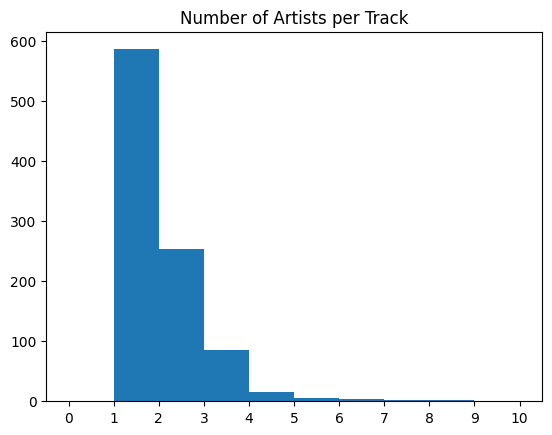

In [196]:
# Evaluate number of artists per track
plt.hist(df["artist_count"], bins=10, range=(0, 10))
plt.title("Number of Artists per Track")
plt.xticks(range(11))
plt.show()
plt.close()
# There are mostly songs with 1 artist, then two, and so on, with the most being 8 in this dataset

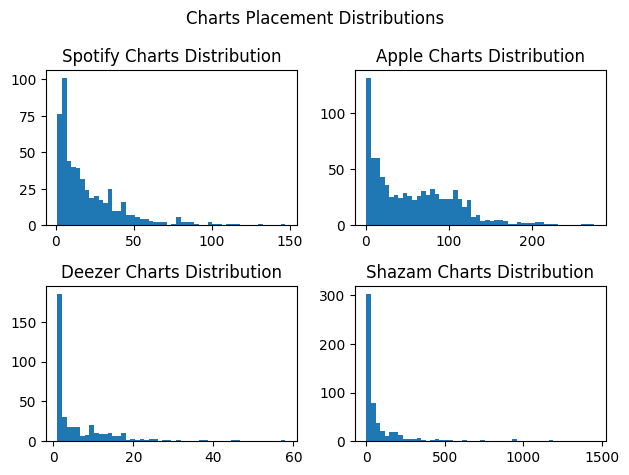

In [197]:
fig, axs = plt.subplots(2, 2)

axs[0, 0].hist(df.replace(0, np.nan)["in_spotify_charts"], bins=50)
axs[0, 0].set_title("Spotify Charts Distribution")
axs[0, 1].hist(df.replace(0, np.nan)["in_apple_charts"], bins=50)
axs[0, 1].set_title("Apple Charts Distribution")
axs[1, 0].hist(df.replace(0, np.nan)["in_deezer_charts"], bins=50)
axs[1, 0].set_title("Deezer Charts Distribution")
axs[1, 1].hist(df.replace(0, np.nan)["in_shazam_charts"], bins=50)
axs[1, 1].set_title("Shazam Charts Distribution")
plt.suptitle("Charts Placement Distributions")
plt.tight_layout()
plt.show()
plt.close()

We see that the songs included are mostly on Spotify and Apple Charts. On Spotify, Deezer, and Shazam charts, there are more songs with higher rankings than not. For Apple charts, while there are many songs at very high rankings, the number of songs ranked between 40 and 100 seem relatively uniform. 

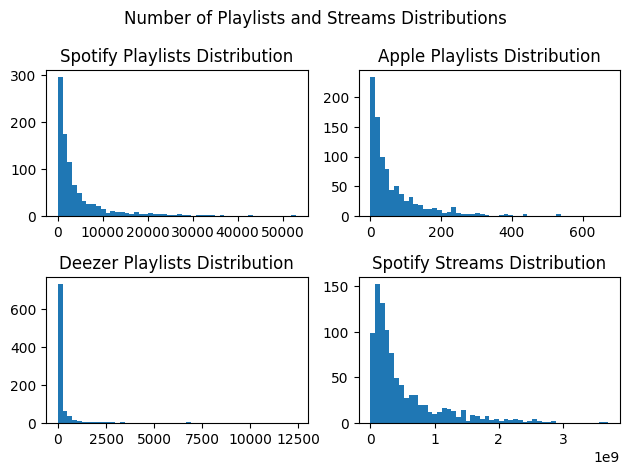

In [198]:
fig, axs = plt.subplots(2, 2)

axs[0, 0].hist(df.replace(0, np.nan)["in_spotify_playlists"], bins=50)
axs[0, 0].set_title("Spotify Playlists Distribution")
axs[0, 1].hist(df.replace(0, np.nan)["in_apple_playlists"], bins=50)
axs[0, 1].set_title("Apple Playlists Distribution")
axs[1, 0].hist(df.replace(0, np.nan)["in_deezer_playlists"], bins=50)
axs[1, 0].set_title("Deezer Playlists Distribution")
axs[1, 1].hist(df.replace(0, np.nan)["streams"], bins=50)
axs[1, 1].set_title("Spotify Streams Distribution")
plt.suptitle("Number of Playlists and Streams Distributions")
plt.tight_layout()
plt.show()
plt.close()

All four of these features appear to follow exponential distributions.

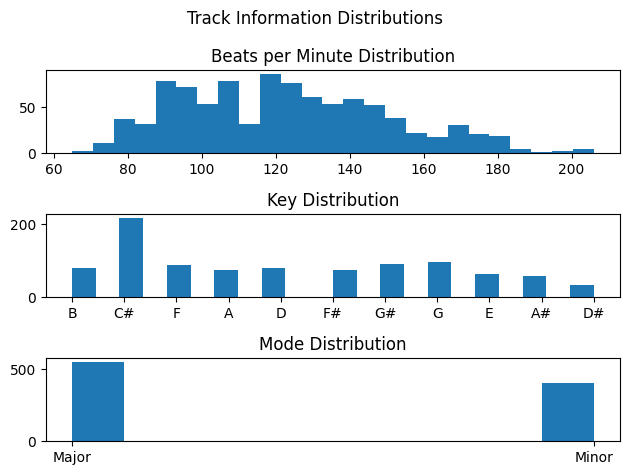

In [199]:
fig, axs = plt.subplots(3)

axs[0].hist(df.replace(0, np.nan)["bpm"], bins=25)
axs[0].set_title("Beats per Minute Distribution")
axs[1].hist(df.replace(0, np.nan)["key"], bins=22)
axs[1].set_title("Key Distribution")
axs[2].hist(df.replace(0, np.nan)["mode"])
axs[2].set_title("Mode Distribution")

plt.suptitle("Track Information Distributions")
plt.tight_layout()
plt.show()
plt.close()

Beats Per Minute is not a normal distribution, but it does have a peak around 120 BPM and it ranges from 60-200. 

Keys are relatively well spread out, with C# being the most used key.

Most songs are in the Major mode, however, there are many in Minor mode.

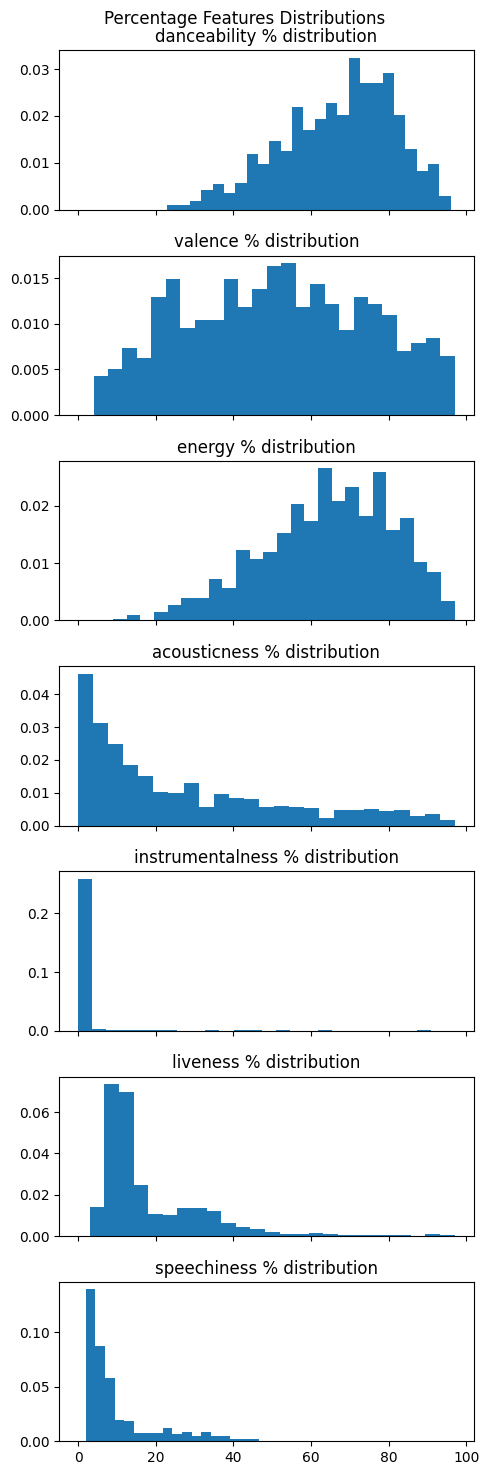

In [200]:
fig, axs = plt.subplots(7, figsize=(5, 15), sharex=True)
percentage_features = [
    "danceability_%",
    "valence_%",
    "energy_%",
    "acousticness_%",
    "instrumentalness_%",
    "liveness_%",
    "speechiness_%",
]
for i in range(7):
    axs[i].hist(df[percentage_features[i]], bins=25, density=True)
    axs[i].set_title(f'{percentage_features[i].replace("_", " ")} distribution')

plt.suptitle("Percentage Features Distributions")
plt.tight_layout()
plt.show()
plt.close()

Dancebility tends to be greater than 50%

Valence is fairly well distributed from 0 to 100% 

Energy appears normal with a high variance and mean around 70%

Acousticness covers the entire spectrum from 0 to 100% but tends to be closer to 0%

Instrumentalness was 0 for most songs.

Liveliness was mostly below 50% with a peak at 10-15%

Speechiness followed an exponential distribution

In [201]:
df["artist(s)_name"].describe()
# Taylor swift is the top artist, of the 952 tracks, there are 644 unique artist names (note that this does not account for multiple artists on a song)

count              952
unique             644
top       Taylor Swift
freq                34
Name: artist(s)_name, dtype: object

In [202]:
# Get a complete list of artists
artists = [
    artist.strip() for row in df["artist(s)_name"].str.split(",") for artist in row
]

In [203]:
# Find ten artists with the most songs
artist_counts = pd.DataFrame.from_dict(
    {artist: artists.count(artist) for artist in set(artists)},
    orient="index",
    columns=["count"],
).sort_values("count", ascending=False)
artist_counts.head(10)

count
Bad Bunny          40
Taylor Swift       38
The Weeknd         37
Kendrick Lamar     23
SZA                23
Feid               21
Drake              19
Harry Styles       17
Peso Pluma         16
Ed Sheeran         14

In [204]:
# Prepare data for training models

# Assign IDs to each track
df["track_id"] = df.index

# Give each artist an ID based on alphabetical order (this will put the tracks
# with multiple artist near at least one of the artists)
artist_names = df.sort_values("artist(s)_name")["artist(s)_name"].unique()
df["artist(s)_id"] = df["artist(s)_name"].map(
    dict(zip(artist_names, range(1, len(artist_names) + 1)))
)

# Combine the release year, month, and day
# start at 0 with the earliest date, assign a release date to each song
start = datetime(1930, 1, 1)
df["release_date"] = [
    (
        datetime(
            df.loc[idx]["released_year"],
            df.loc[idx]["released_month"],
            df.loc[idx]["released_day"],
        )
        - start
    ).days
    for idx in df.index
]
df.drop(["released_year", "released_month", "released_day"], axis=1, inplace=True)

In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            952 non-null    object
 1   artist(s)_name        952 non-null    object
 2   artist_count          952 non-null    int64 
 3   in_spotify_playlists  952 non-null    int64 
 4   in_spotify_charts     952 non-null    int64 
 5   streams               952 non-null    int64 
 6   in_apple_playlists    952 non-null    int64 
 7   in_apple_charts       952 non-null    int64 
 8   in_deezer_playlists   952 non-null    int64 
 9   in_deezer_charts      952 non-null    int64 
 10  in_shazam_charts      952 non-null    int64 
 11  bpm                   952 non-null    int64 
 12  key                   952 non-null    object
 13  mode                  952 non-null    object
 14  danceability_%        952 non-null    int64 
 15  valence_%             952 non-null    int64 


In [206]:
(df.select_dtypes(int, float).corr() - pd.DataFrame(np.eye(20), columns=df.select_dtypes(int, float).columns, index=df.select_dtypes(int, float).columns))

artist_count  in_spotify_playlists  in_spotify_charts  \
artist_count              0.000000             -0.102184          -0.018916   
in_spotify_playlists     -0.102184              0.000000           0.164182   
in_spotify_charts        -0.018916              0.164182           0.000000   
streams                  -0.136463              0.789822           0.245821   
in_apple_playlists       -0.051487              0.708258           0.233057   
in_apple_charts          -0.089336              0.271162           0.551985   
in_deezer_playlists      -0.071716              0.826388           0.088190   
in_deezer_charts         -0.004022              0.144227           0.600101   
in_shazam_charts         -0.013063              0.057411           0.569487   
bpm                      -0.038680             -0.019739           0.034435   
danceability_%            0.206543             -0.106885           0.029475   
valence_%                 0.128712             -0.021585           0.036205   
energy_%                  0.137317              0.033899           0.082124   
acousticness_%           -0.101619             -0.064683          -0.055513   
instrumentalness_%       -0.050359             -0.028194          -0.010270   
liveness_%                0.042681             -0.046725          -0.047619   
speechiness_%             0.119486             -0.089973          -0.082267   
track_id                 -0.015698             -0.100931          -0.635806   
artist(s)_id             -0.074268             -0.069327          -0.026426   
release_date              0.086342             -0.399453           0.066111   

                       streams  in_apple_playlists  in_apple_charts  \
artist_count         -0.136463           -0.051487        -0.089336   
in_spotify_playlists  0.789822            0.708258         0.271162   
in_spotify_charts     0.245821            0.233057         0.551985   
streams               0.000000            0.772063         0.320234   
in_apple_playlists    0.772063            0.000000         0.414184   
in_apple_charts       0.320234            0.414184         0.000000   
in_deezer_playlists   0.598131            0.472034         0.173330   
in_deezer_charts      0.228598            0.368862         0.383443   
in_shazam_charts     -0.006434            0.099866         0.401271   
bpm                  -0.002438            0.023450         0.030500   
danceability_%       -0.105457           -0.025945        -0.026260   
valence_%            -0.040831            0.057749         0.048868   
energy_%             -0.026051            0.052807         0.105199   
acousticness_%       -0.004485           -0.062299        -0.077692   
instrumentalness_%   -0.044902           -0.057349        -0.013356   
liveness_%           -0.048337           -0.049662        -0.018839   
speechiness_%        -0.112333           -0.108515        -0.152440   
track_id             -0.178757           -0.135584        -0.408184   
artist(s)_id         -0.084785           -0.055787        -0.058529   
release_date         -0.230814           -0.203211        -0.041382   

                      in_deezer_playlists  in_deezer_charts  in_shazam_charts  \
artist_count                    -0.071716         -0.004022         -0.013063   
in_spotify_playlists             0.826388          0.144227          0.057411   
in_spotify_charts                0.088190          0.600101          0.569487   
streams                          0.598131          0.228598         -0.006434   
in_apple_playlists               0.472034          0.368862          0.099866   
in_apple_charts                  0.173330          0.383443          0.401271   
in_deezer_playlists              0.000000          0.066466          0.065742   
in_deezer_charts                 0.066466          0.000000          0.395686   
in_shazam_charts                 0.065742          0.395686          0.000000   
bpm                             -0.035539          0.027834 

In [207]:
df

track_name      artist(s)_name  artist_count  \
0    Seven (feat. Latto) (Explicit Ver.)    Latto, Jung Kook             2   
1                                   LALA         Myke Towers             1   
2                                vampire      Olivia Rodrigo             1   
3                           Cruel Summer        Taylor Swift             1   
4                         WHERE SHE GOES           Bad Bunny             1   
..                                   ...                 ...           ...   
948                         My Mind & Me        Selena Gomez             1   
949            Bigger Than The Whole Sky        Taylor Swift             1   
950                 A Veces (feat. Feid)  Feid, Paulo Londra             2   
951                        En La De Ella  Feid, Sech, Jhayco             3   
952                                Alone           Burna Boy             1   

     in_spotify_playlists  in_spotify_charts    streams  in_apple_playlists  \
0                     553                147  141381703                  43   
1                    1474                 48  133716286                  48   
2                    1397                113  140003974                  94   
3                    7858                100  800840817                 116   
4                    3133                 50  303236322                  84   
..                    ...                ...        ...                 ...   
948                   953                  0   91473363                  61   
949                  1180                  0  121871870                   4   
950                   573                  0   73513683                   2   
951                  1320                  0  133895612                  29   
952                   782                  2   96007391                  27   

     in_apple_charts  in_deezer_playlists  in_deezer_charts  ...  \
0                263                   45                10  ...   
1                126                   58                14  ...   
2                207                   91                14  ...   
3                207                  125                12  ...   
4                133                   87                15  ...   
..               ...                  ...               ...  ...   
948               13                   37                 1  ...   
949                0                    8                 0  ...   
950                0                    7                 0  ...   
951               26                   17                 0  ...   
952               18                   32                 1  ...   

     danceability_%  valence_% energy_% acousticness_%  instrumentalness_%  \
0                80         89       83             31                   0   
1                71         61       74              7                   0   
2                51         32       53             17                   0   
3                55         58       72             11                   0   
4                65         23       80             14                  63   
..              ...        ...      ...            ...                 ...   
948              60         24       39             57                   0   
949              42          7       24             83                   1   
950              80         81       67              4                   0   
951              82         67       77              8                   0   
952              61         32       67             15                   0   

     liveness_%  speechiness_%  track_id  artist(s)_id  release_date  
0             8              4         0           326         34162  
1            10              4         1           401         34049  
2            31              6         2           431         34148  
3            11             15         3           558         32741  
4            11              6     

## III. Analysis - Model Building and Training

In [208]:
# Get train and test data
target = "track_name"
X = df.select_dtypes(int).drop("track_id", axis=1)
y = df[[target, "artist(s)_name"]]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)
# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [209]:
# Nearest Neighbors Clustering with a ball tree algorithm
# Fit training data
clustering = NearestNeighbors(n_neighbors=2, algorithm="ball_tree").fit(X_train)
# Map track names to their 2 nearest neighbors
train_result = clustering.kneighbors(X_train)
test_result = clustering.kneighbors(X_test)
train_prediction_mapping = dict(
    zip([val[0] + " by " + val[1] for val in y_train.values], train_result[1])
)
test_prediction_mapping = dict(
    zip([val[0] + " by " + val[1] for val in y_test.values], test_result[1])
)

The NearestNeighbors algorithm with ball_tree, returns a nearest neighbor and their distance from the input. Since we do not have true target labels available, we visualize the accuracy of the model by viewing the distance of the neighbors.

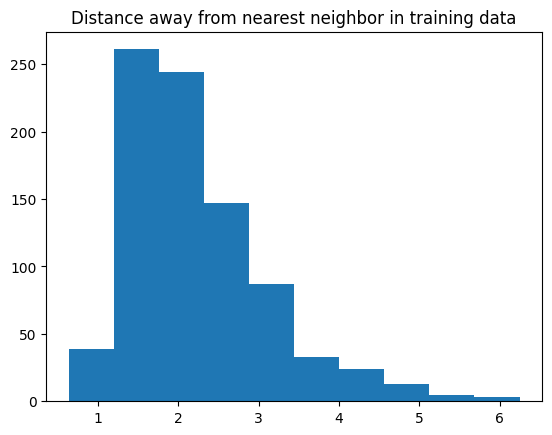

In [210]:
# We use the distance at index 1 because the distance at index 0 is always 0 for training data
# This is because the nearest neighbor is the same point
plt.hist([distances[1] for distances in train_result[0]])
plt.title("Distance away from nearest neighbor in training data")
plt.show()
plt.close()

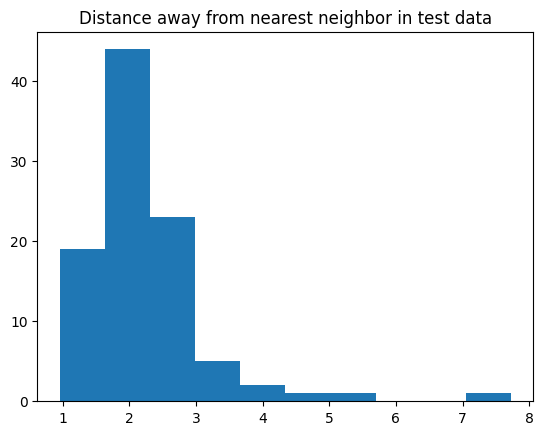

In [211]:
plt.hist([distances[0] for distances in test_result[0]])
plt.title("Distance away from nearest neighbor in test data")
plt.show()
plt.close()

The test data has similar distances to nearest neighbors as the train data.
This is a good sign that the model is not overfit. 

In [212]:
for listening_to, predictions in test_prediction_mapping.items():
    recommendations = [
        y_train.values[prediction][0] + " by " + y_train.values[prediction][1]
        for prediction in predictions
    ]
    print(f"If you are listening to: {listening_to}")
    print(f"You might like {recommendations}")
    print()

If you are listening to: Take On Me by a-ha
You might like ['In The End by Linkin Park', 'Still D.R.E. by Dr. Dre, Snoop Dogg']

If you are listening to: Rumble by Skrillex, Flowdan, Fred again..
You might like ['Watch This - ARIZONATEARS Pluggnb Remix by sped up nightcore, ARIZONATEARS, Lil Uzi Vert', 'Mami Chula by Quevedo, Jhayco']

If you are listening to: Adore You by Harry Styles
You might like ['Save Your Tears (with Ariana Grande) (Remix) by Ariana Grande, The Weeknd', 'Woman by Doja Cat']

If you are listening to: Sigue by Ed Sheeran, J Balvin
You might like ['Thinking with My Dick by Kevin Gates, Juicy J', 'Superman by Eminem, Dina Rae']

If you are listening to: Pepas by Farruko
You might like ['Bad Habits by Ed Sheeran', 'Shivers by Ed Sheeran']

If you are listening to: Fair Trade (with Travis Scott) by Drake, Travis Scott
You might like ['Rich Flex by Drake, 21 Savage', 'Jimmy Cooks (feat. 21 Savage) by Drake, 21 Savage']

If you are listening to: Yet To Come by BTS
You m

By performing a qualitative scan of the recommendations, I believe that there is room for improvement. I start by performing feature reduction to see if any natural clustering by a particular feature (column) of the data is evident. 

In [213]:
features_of_interest = df.columns

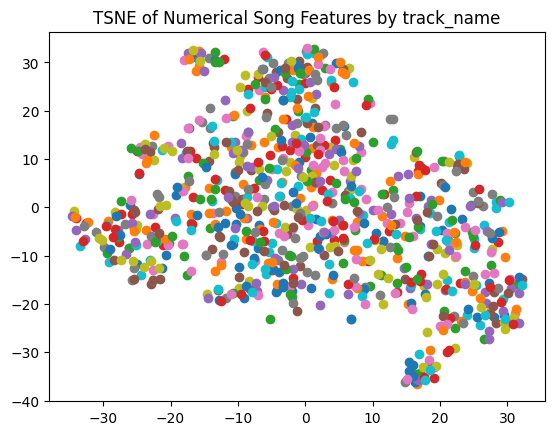

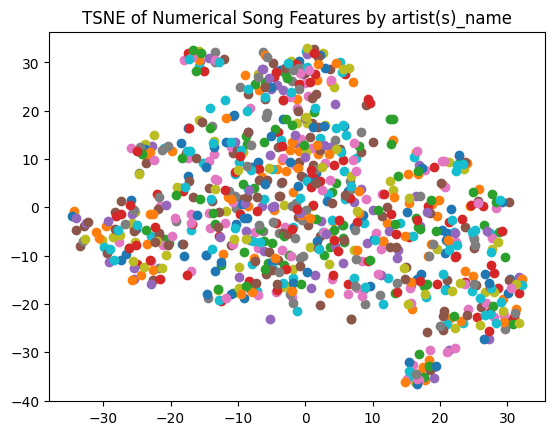

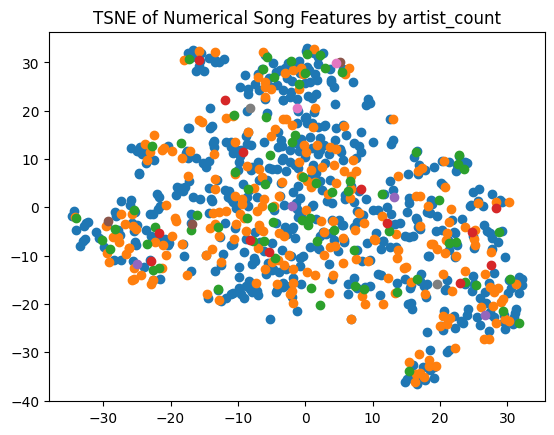

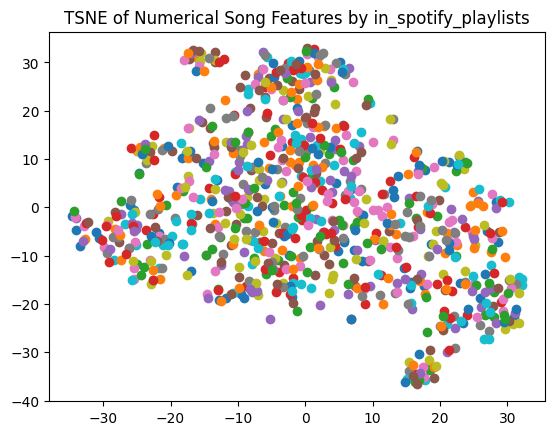

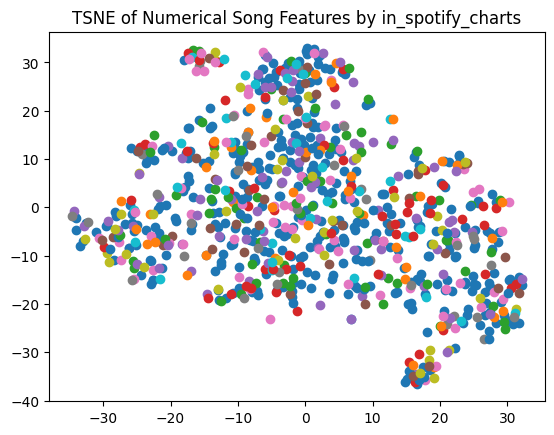

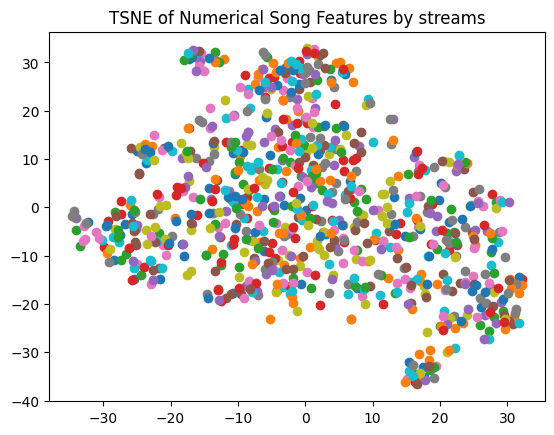

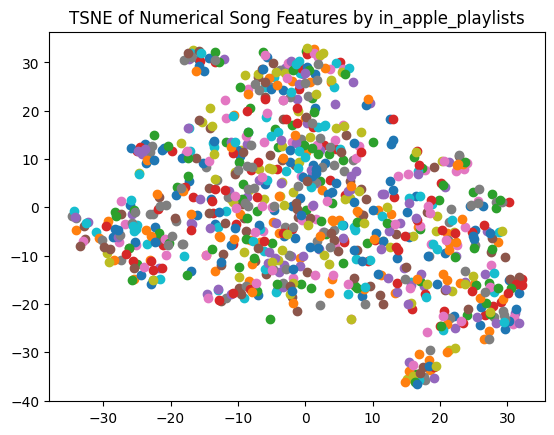

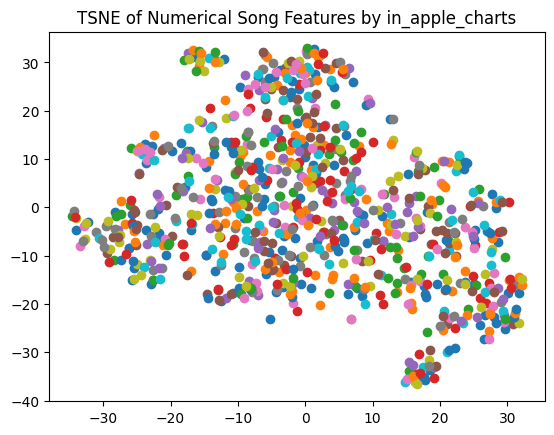

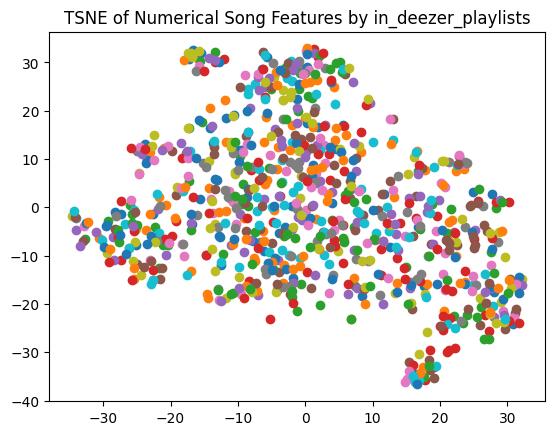

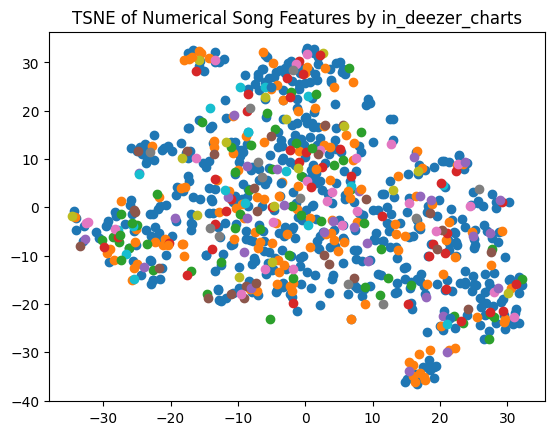

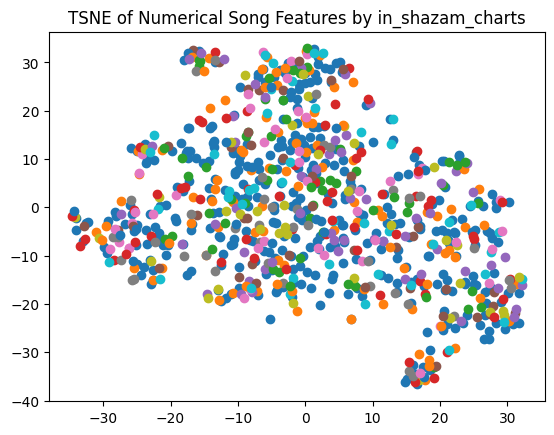

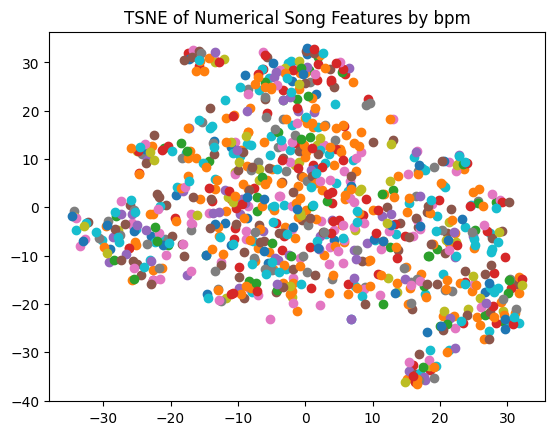

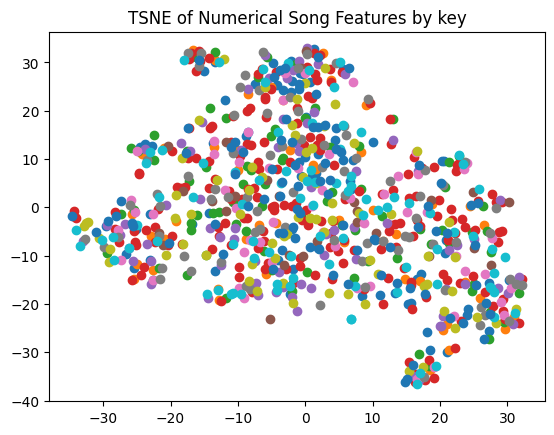

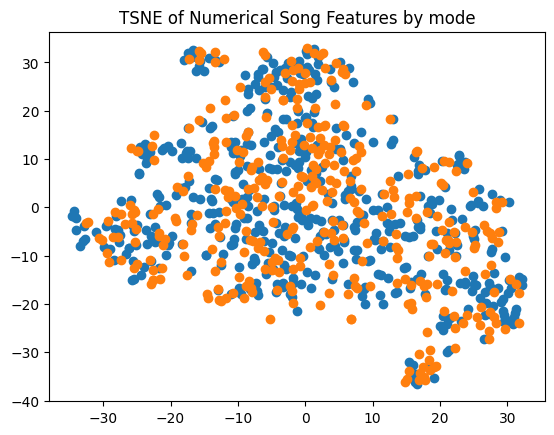

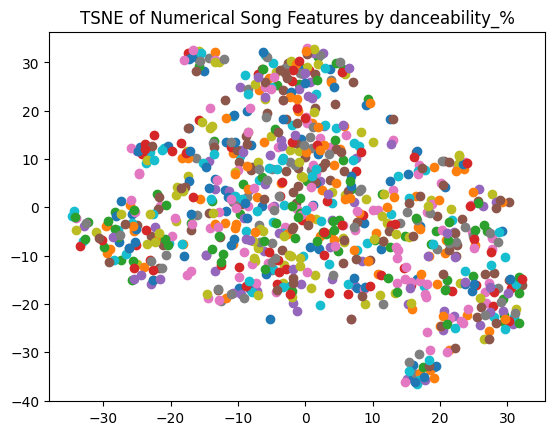

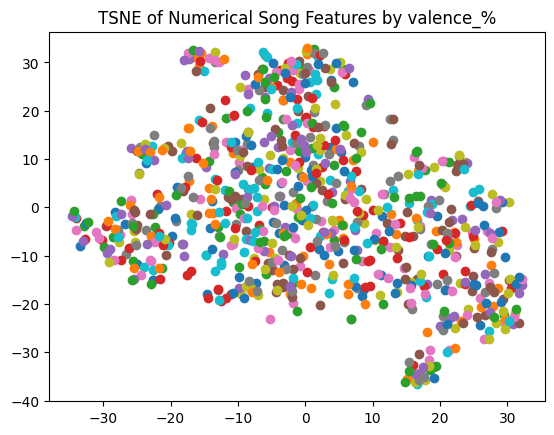

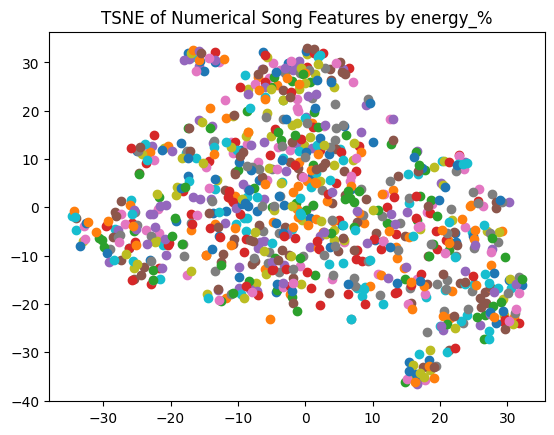

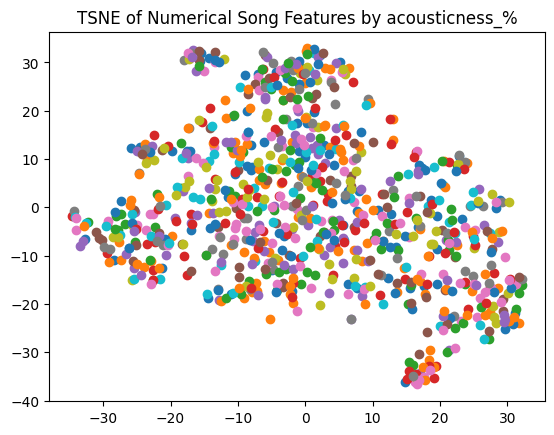

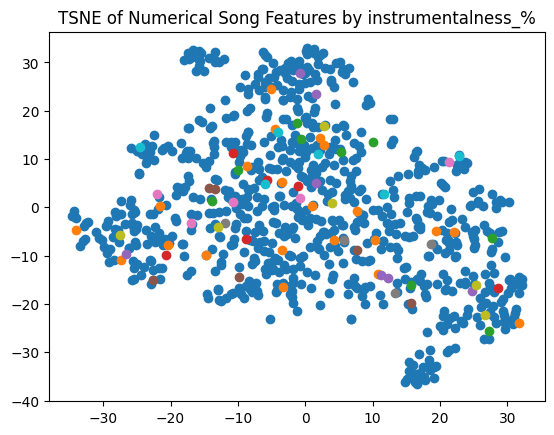

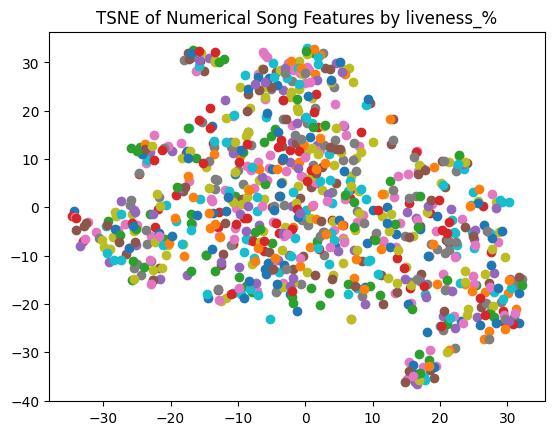

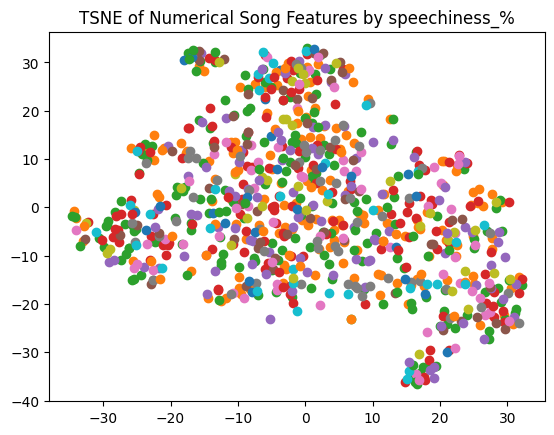

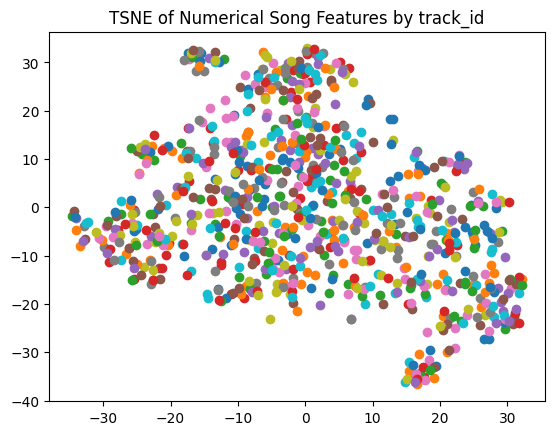

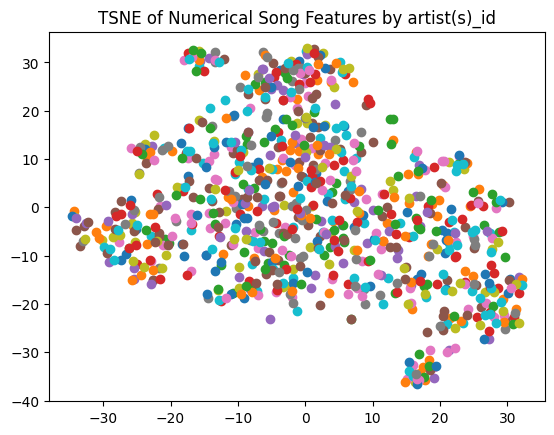

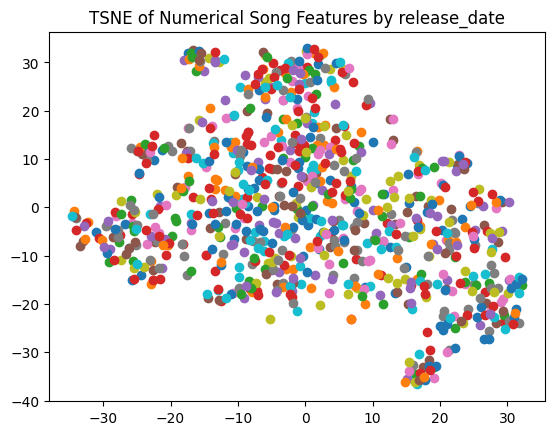

In [214]:
tsne = TSNE(n_components=2)
reduced_features = tsne.fit_transform(X_train)
tsne_df = pd.DataFrame(reduced_features, columns=["TSNE1", "TSNE2"])
for feature in features_of_interest:
    tsne_df[feature] = df[feature]
    for entry in tsne_df.groupby(feature):
        plt.scatter(
            entry[1]["TSNE1"],
            entry[1]["TSNE2"],
            label=entry[0],
        )
    plt.title(f"TSNE of Numerical Song Features by {feature}")
    plt.show()
    plt.close()

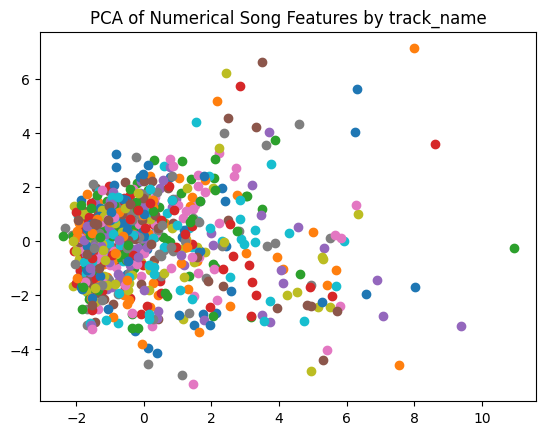

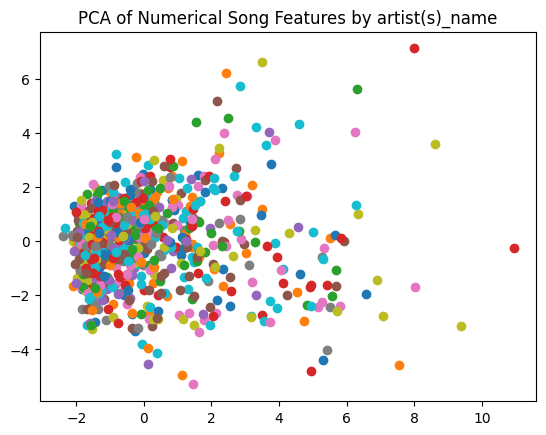

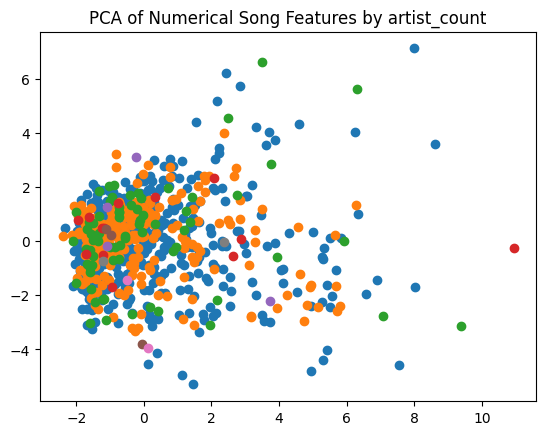

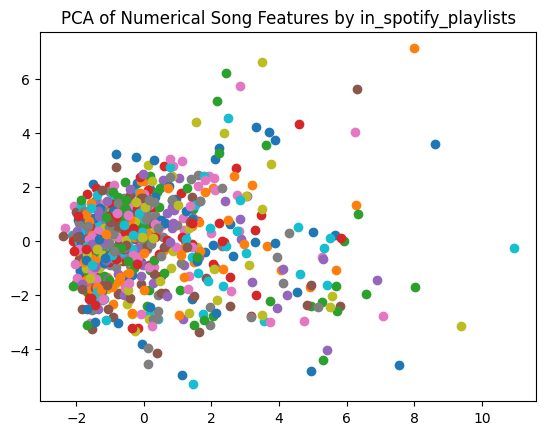

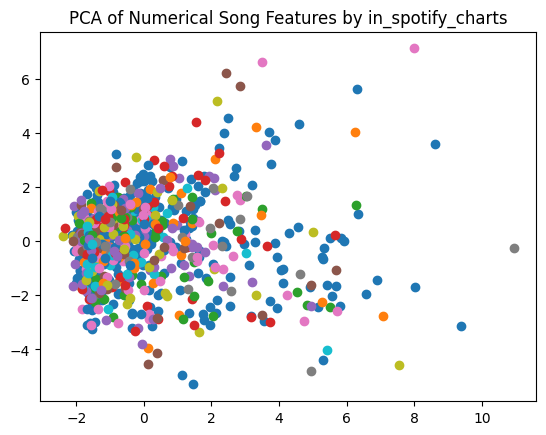

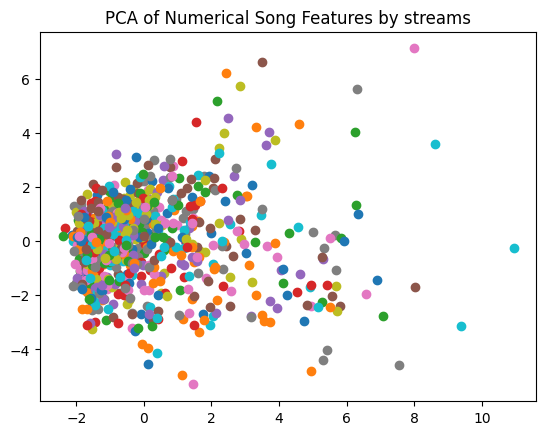

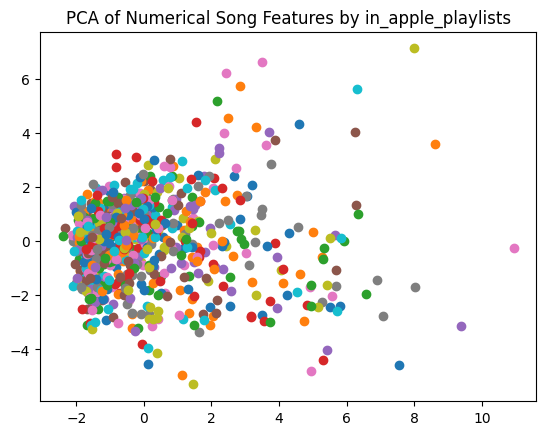

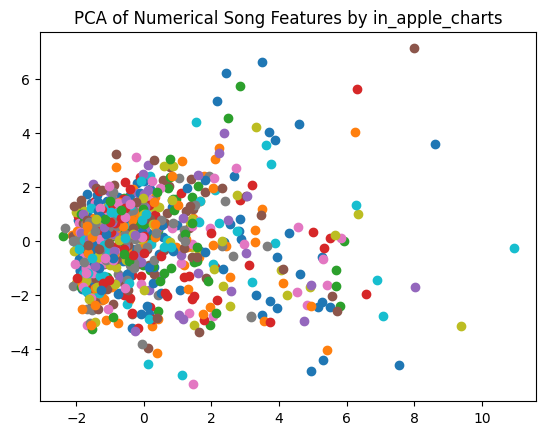

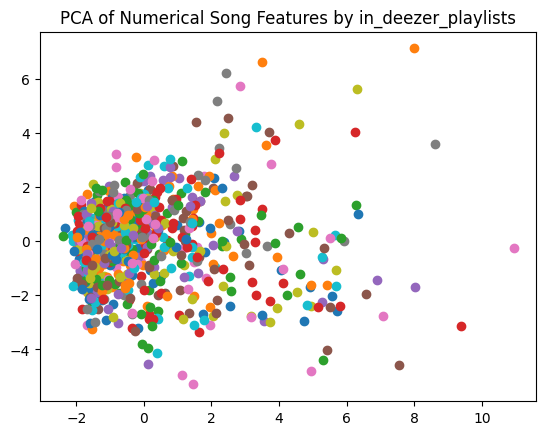

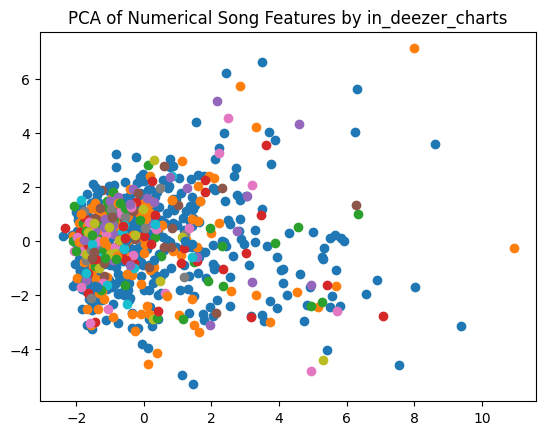

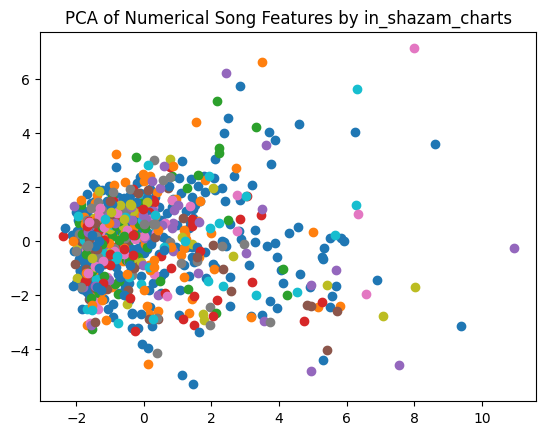

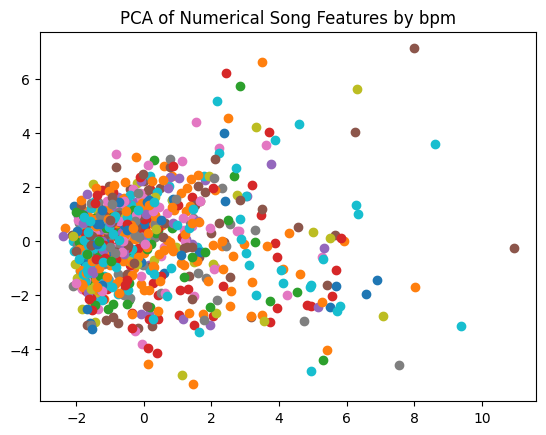

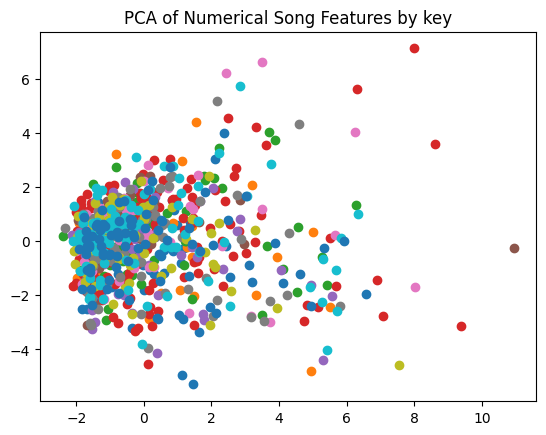

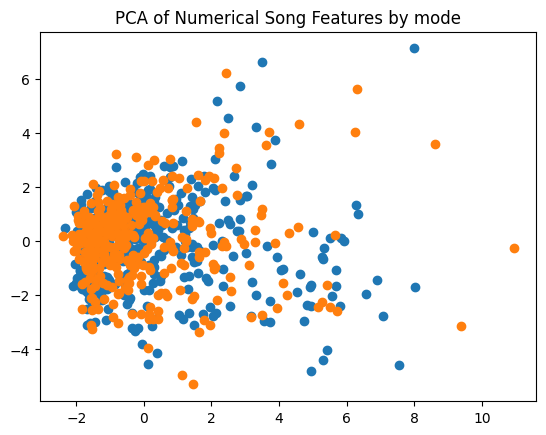

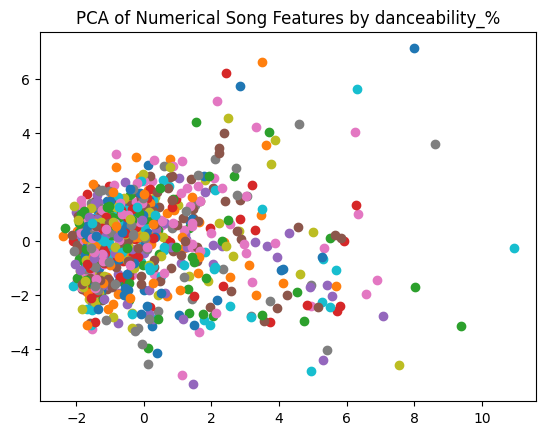

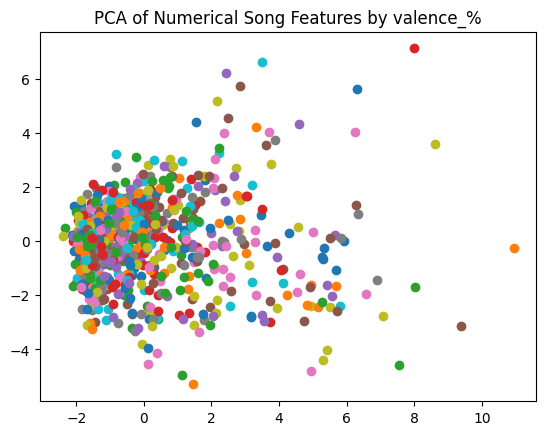

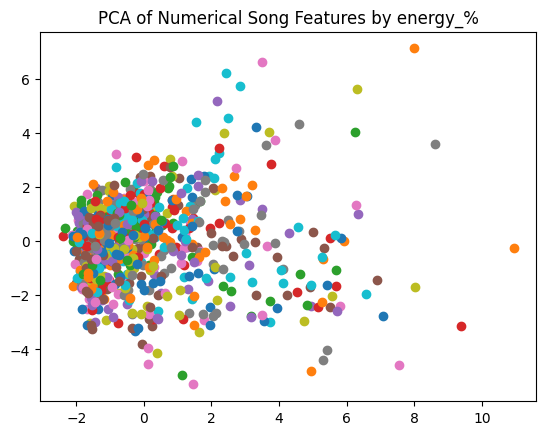

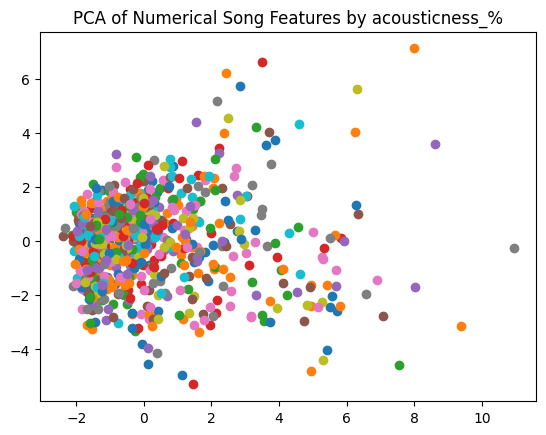

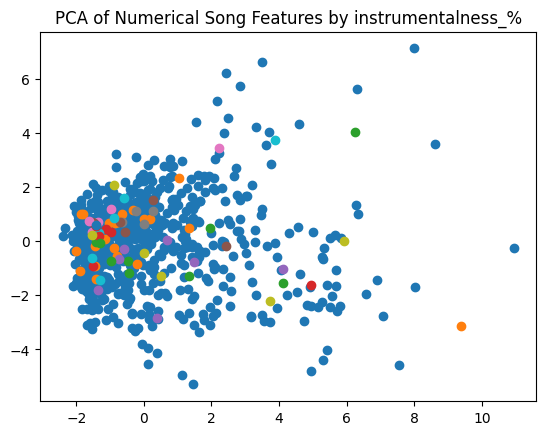

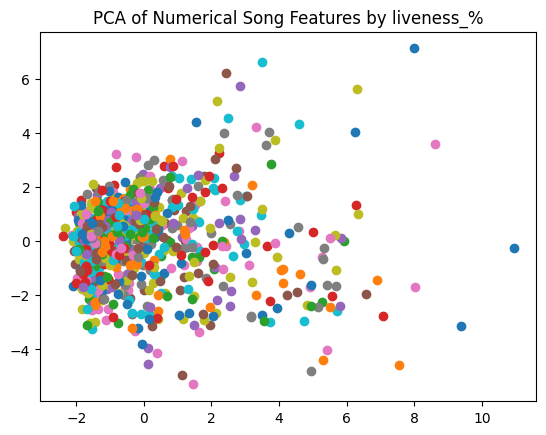

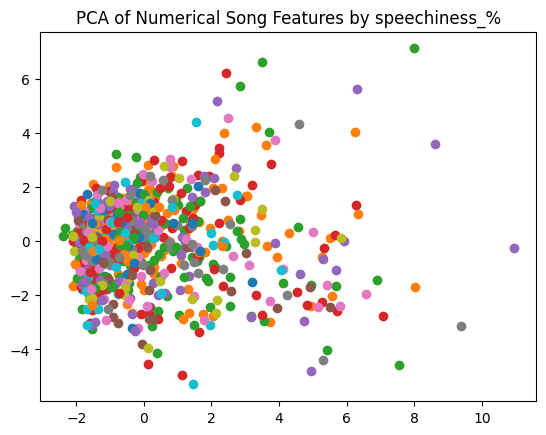

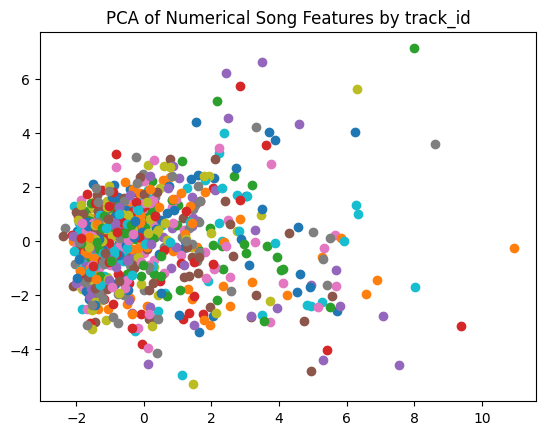

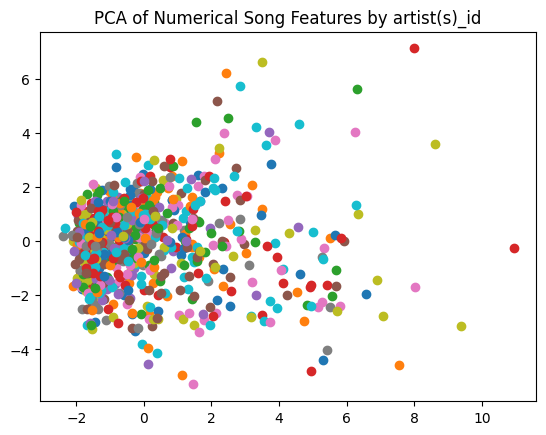

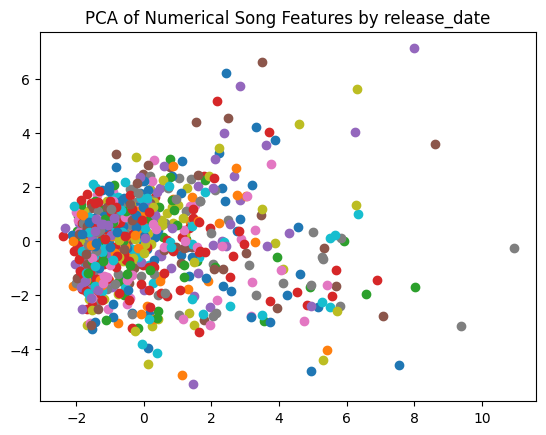

In [215]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X_train)
pca_df = pd.DataFrame(reduced_features, columns=["PCA1", "PCA2"])
for feature in features_of_interest:
    pca_df[feature] = df[feature]
    for entry in pca_df.groupby(feature):
        plt.scatter(
            entry[1]["PCA1"],
            entry[1]["PCA2"],
            label=entry[0],
        )
    plt.title(f"PCA of Numerical Song Features by {feature}")
    plt.show()
    plt.close()

TODO Summarize Results of the dimensionality reduction

Key and Mode might have an affect on the recommendations, so we use one hot encoding to convert the strings to integers for usability in the model. Then, we retrain the clustering model. 

In [216]:
# Encode key and map as ints
key_map = dict(zip(sorted(df['key'].unique()), range(11)))
mode_map = dict(zip(sorted(df['mode'].unique()), range(2)))
df['key'].replace(key_map, inplace=True)
df['mode'].replace(mode_map, inplace=True)

In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            952 non-null    object
 1   artist(s)_name        952 non-null    object
 2   artist_count          952 non-null    int64 
 3   in_spotify_playlists  952 non-null    int64 
 4   in_spotify_charts     952 non-null    int64 
 5   streams               952 non-null    int64 
 6   in_apple_playlists    952 non-null    int64 
 7   in_apple_charts       952 non-null    int64 
 8   in_deezer_playlists   952 non-null    int64 
 9   in_deezer_charts      952 non-null    int64 
 10  in_shazam_charts      952 non-null    int64 
 11  bpm                   952 non-null    int64 
 12  key                   952 non-null    int64 
 13  mode                  952 non-null    int64 
 14  danceability_%        952 non-null    int64 
 15  valence_%             952 non-null    int64 


In [218]:
# Retrain clustering model. redo predictions
# Get train and test data
target = "track_name"
X = df.select_dtypes(int).drop("track_id", axis=1)
y = df[[target, "artist(s)_name"]]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)
# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [219]:
# Nearest Neighbors Clustering with a ball tree algorithm
# Fit training data
clustering = NearestNeighbors(n_neighbors=2, algorithm="ball_tree").fit(X_train)
# Map track names to their 2 nearest neighbors
train_result = clustering.kneighbors(X_train)
test_result = clustering.kneighbors(X_test)
train_prediction_mapping = dict(
    zip([val[0] + " by " + val[1] for val in y_train.values], train_result[1])
)
test_prediction_mapping = dict(
    zip([val[0] + " by " + val[1] for val in y_test.values], test_result[1])
)

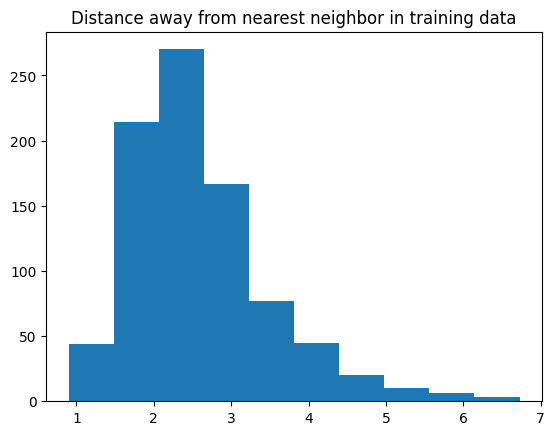

In [220]:
# We use the distance at index 1 because the distance at index 0 is always 0 for training data
# This is because the nearest neighbor is the same point
plt.hist([distances[1] for distances in train_result[0]])
plt.title("Distance away from nearest neighbor in training data")
plt.show()
plt.close()

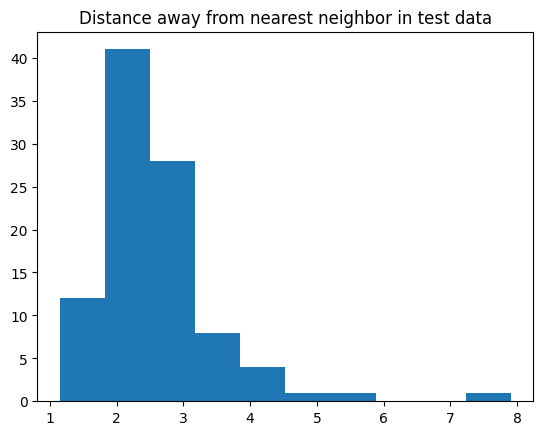

In [221]:
plt.hist([distances[0] for distances in test_result[0]])
plt.title("Distance away from nearest neighbor in test data")
plt.show()
plt.close()

In [222]:
for listening_to, predictions in test_prediction_mapping.items():
    recommendations = [
        y_train.values[prediction][0] + " by " + y_train.values[prediction][1]
        for prediction in predictions
    ]
    print(f"If you are listening to: {listening_to}")
    print(f"You might like {recommendations}")
    print()

If you are listening to: Take On Me by a-ha
You might like ['In The End by Linkin Park', 'Get Lucky - Radio Edit by Pharrell Williams, Nile Rodgers, Daft Punk']

If you are listening to: Rumble by Skrillex, Flowdan, Fred again..
You might like ['Watch This - ARIZONATEARS Pluggnb Remix by sped up nightcore, ARIZONATEARS, Lil Uzi Vert', 'Freaky Deaky by Tyga, Doja Cat']

If you are listening to: Adore You by Harry Styles
You might like ['Leave Before You Love Me (with Jonas Brothers) by Marshmello, Jonas Brothers', 'Save Your Tears (with Ariana Grande) (Remix) by Ariana Grande, The Weeknd']

If you are listening to: Sigue by Ed Sheeran, J Balvin
You might like ['X ï¿½ï¿½LTIMA by Daddy Yankee, Bad Bunny', 'ZOOM by Jessi']

If you are listening to: Pepas by Farruko
You might like ['CUFF IT by Beyoncï¿', 'Shivers by Ed Sheeran']

If you are listening to: Fair Trade (with Travis Scott) by Drake, Travis Scott
You might like ['Jimmy Cooks (feat. 21 Savage) by Drake, 21 Savage', 'Rich Flex by D

Through a qualitiative lens the recommendations are similar but slightly improved. Let's use different algorithms for computing nearest neighbor to see if the average distance from the neighbor is reduced.

In [225]:
# Algorithm used to compute the nearest neighbors:
# ‘ball_tree’ will use BallTree
# ‘kd_tree’ will use KDTree
# ‘brute’ will use a brute-force search.

algs = ['ball_tree', 'kd_tree', 'brute']
for alg in algs:
    clustering = NearestNeighbors(n_neighbors=2, algorithm=alg).fit(X_train)
    # Map track names to their 2 nearest neighbors
    train_result = clustering.kneighbors(X_train)
    test_result = clustering.kneighbors(X_test)
    print(f"Algorithm: {alg}")
    print(f"Training data average distance from nearest neighbor: {np.array([distances[1] for distances in train_result[0]]).mean()}")
    print(f"Testing data average distance from nearest neighbor: {np.array([distances[0] for distances in test_result[0]]).mean()}")
    print()

Algorithm: ball_tree
Training data average distance from nearest neighbor: 2.589590441368822
Testing data average distance from nearest neighbor: 2.604677777482167

Algorithm: kd_tree
Training data average distance from nearest neighbor: 2.589590441368822
Testing data average distance from nearest neighbor: 2.604677777482167

Algorithm: brute
Training data average distance from nearest neighbor: 2.589590441368822
Testing data average distance from nearest neighbor: 2.604677777482167



## IV. Result

Algorithm used in final model: Nearest Neighbors with ball_tree algorithm

Training data average distance from nearest neighbor: 2.589590441368822

Testing data average distance from nearest neighbor: 2.604677777482167


Given a song that you are listening to, this algorithm can provide two song recommendations. Below are some example recommendations:


If you are listening to: Adore You by Harry Styles, you might like ['Leave Before You Love Me (with Jonas Brothers) by Marshmello, Jonas Brothers', 'Save Your Tears (with Ariana Grande) (Remix) by Ariana Grande, The Weeknd']

If you are listening to: Fair Trade (with Travis Scott) by Drake, Travis Scott, you might like ['Jimmy Cooks (feat. 21 Savage) by Drake, 21 Savage', 'Rich Flex by Drake, 21 Savage']

If you are listening to: Yet To Come by BTS, you might like ['Nosso Quadro by Ana Castela, AgroPlay', 'Permission to Dance by BTS']

If you are listening to: BREAK MY SOUL by Beyonce, you might like ['About Damn Time by Lizzo', 'Levitating by Dua Lipa']

## V. Discussion and Conclusion

Although there is not a concrete, numerical evaluation of this algorithm, as true labels for best song recommendation are not available. Based on the distances between nearest neighbors and a qualitative review of the recommendations, I believe this algorithm does a good job at providing similar songs. The PCA and tSNE analysis did not provide as much insight into the data as hoped. It is possible that the data lost meaning when reduced to two features or that multiple features of interest were necessary for predicting similar songs. 